#Anomaly Detection with Adaptive Fourier Features and DMKDE Quantum Algorithm in Real Quantum Computer

## Imports and Data load

In [ ]:
!pip install qiskit==0.35.0
!pip install pylatexenc

     |████████████████████████████████| 6.5 MB 3.3 MB/s 
     |████████████████████████████████| 18.0 MB 78 kB/s 
     |████████████████████████████████| 238 kB 49.2 MB/s 
     |████████████████████████████████| 200 kB 44.7 MB/s 
     |████████████████████████████████| 54 kB 2.2 MB/s 
     |████████████████████████████████| 1.6 MB 43.2 MB/s 
     |████████████████████████████████| 38.1 MB 24.6 MB/s 
     |████████████████████████████████| 943 kB 38.1 MB/s 
     |████████████████████████████████| 49 kB 4.7 MB/s 
     |████████████████████████████████| 49 kB 4.0 MB/s 
     |████████████████████████████████| 37.5 MB 1.6 MB/s 
     |████████████████████████████████| 4.0 MB 45.7 MB/s 
     |████████████████████████████████| 112 kB 48.6 MB/s 
  Created wheel for qiskit: filename=qiskit-0.35.0-py3-none-any.whl size=11839 sha256=d45d50f608d3d9383b5b25d8de314b4fecee80eacb5628e09d08379187d10e24
  Stored in directory: /root/.cache/pip/wheels/1e/0a/42/93e5cc11795fb0a85fcf6686eac2791def0c9a1cad0a77

## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load from drive .mat file

In [ ]:
!pip install --upgrade --no-cache-dir gdown

In [ ]:
#Loading .mat Cardiotocography dataset file
!gdown 1j4qIus2Bl44Om0UiOu4o4f__wVwUeDfP

Downloading...
From: https://drive.google.com/uc?id=1j4qIus2Bl44Om0UiOu4o4f__wVwUeDfP
To: /content/cardio.mat
100% 68.3k/68.3k [00:00<00:00, 51.4MB/s]


In [ ]:
import numpy as np
from time import time
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


# cardio = np.load("Cardiotocography.npy")

from scipy import io

cardio = io.loadmat("cardio.mat")

cardio["X"].shape, cardio["y"].shape

((1831, 21), (1831, 1))

Preprocessing

np.load object --> X, y (scaled)

normal: '1'  
anomalies: '0'

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore

def preprocessing_cardio(data):
  features, labels = cardio["X"], cardio["y"]
  labels = 1 - labels

  # scaler = MinMaxScaler()
  # scaler.fit(features)
  # features = scaler.transform(features)

  return features, labels

cardio_X, cardio_y = preprocessing_cardio(cardio)

cardio_X.shape, cardio_y.shape

((1831, 21), (1831, 1))

## Random Fourier Features

parameters: gamma, dimensions, random_state

X --> rff(X)

In [ ]:
from sklearn.kernel_approximation import RBFSampler
"""
  Code from https://arxiv.org/abs/2004.01227
"""
class QFeatureMap: 

  def get_dim(self, num_features):
    pass

  def batch2wf(self, X):
    pass

  def batch2dm(self, X):
    psi = self.batch2wf(X)
    rho = np.einsum('...i,...j', psi, np.conj(psi))
    return rho

class QFeatureMap_rff(QFeatureMap):

  def __init__(self, rbf_sampler):
    self.rbf_sampler = rbf_sampler
    self.weights = np.array(rbf_sampler.random_weights_)
    self.offset = np.array(rbf_sampler.random_offset_)
    self.dim = rbf_sampler.get_params()['n_components']

  def get_dim(self, num_features):
    return self.dim

  def batch2wf(self, X):
    vals = np.dot(X, self.weights) + self.offset
    vals = np.cos(vals)
    vals *= np.sqrt(2.) / np.sqrt(self.dim)
    norms = np.linalg.norm(vals, axis=1)
    psi = vals / norms[:, np.newaxis]
    return psi

In [ ]:
# Create the RandomFourierFeature map
def rff(X, dim, gamma): 
    feature_map_fourier = RBFSampler(gamma=gamma, n_components=dim, random_state=2)
    X_feat_train = feature_map_fourier.fit(cardio_X)

    rffmap = QFeatureMap_rff(rbf_sampler=feature_map_fourier)
    Crff = rffmap.batch2wf(cardio_X)

    return Crff

Train test split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(cardio_X, cardio_y, test_size=0.2, stratify=cardio_y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=42)

print(f"shape of X_train: {X_train.shape} X_test: {X_test.shape} X_val {X_val.shape}")
n_classes = np.bincount(y_test.ravel().astype(np.int64))

print(f"classes: 0: {n_classes[0]} 1: {n_classes[1]} %-anomalies: {n_classes[0] / (n_classes[0] + n_classes[1])}")
#print(f"classes: 0: {n_classes[0]} 1: {n_classes[1]} %-anomalies: {n_classes[1] / (n_classes[0] + n_classes[1])}")

shape of X_train: (1098, 21) X_test: (367, 21) X_val (366, 21)
classes: 0: 35 1: 332 %-anomalies: 0.09536784741144415


## Quantum Prediction

Density Matrix Build

Pure State: x_train --> U (matrix)

Mixed State: X_train --> lambda (vec) , U (matrix)

In [ ]:
def pure_state(Ctrain):
    phi_train = np.sum(Ctrain, axis=0)
    phi_train = phi_train / np.linalg.norm(phi_train)

    size_U = len(phi_train)
    U_train = np.zeros((size_U, size_U))
    x_1 = phi_train
    U_train[:, 0] = x_1
    for i in range(1, size_U):
        x_i = np.random.randn(size_U)
        for j in range(0, i):
            x_i -= x_i.dot(U_train[:, j]) * U_train[:, j]
        x_i = x_i / np.linalg.norm(x_i)
        U_train[:, i] = x_i

    return U_train

In [ ]:
def mixed_state(Ctrain):
    
    Z_train = np.outer(Ctrain[0], Ctrain[0])
    for i in range(1, len(Ctrain)):
        Z_train += np.outer(Ctrain[i], Ctrain[i])


    Z_train *= 1/len(Ctrain)

    lambda_P1_temp, U_train = np.linalg.eigh(Z_train)

    return lambda_P1_temp, U_train

In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import Aer, execute

from sklearn.metrics import classification_report

# Quantum Prediction with Adaptive RFF

## Clone the QMC from GitHUB

In [ ]:
!pip install git+https://github.com/fagonzalezo/qmc.git

  Cloning https://github.com/fagonzalezo/qmc.git to /tmp/pip-req-build-q8o_4u57
  Running command git clone -q https://github.com/fagonzalezo/qmc.git /tmp/pip-req-build-q8o_4u57
     |████████████████████████████████| 462 kB 3.9 MB/s 
  Created wheel for qmc: filename=qmc-0.0.1-py3-none-any.whl size=12757 sha256=01a3ab1f0e1e16f07622b97229a5bff6367725e98b50c351a9c6ff911f62cc30
  Stored in directory: /tmp/pip-ephem-wheel-cache-kmaafbet/wheels/b2/d2/8d/5870208920445c46dfe694f549251e5f63d7afbee56c01f720
Successfully built qmc


## Adaptive RFF

In [ ]:
import tensorflow as tf
import numpy as np
import qmc.tf.layers as layers
import qmc.tf.models as models

In [ ]:
import pylab as pl

(100000,)
0.265800883135551


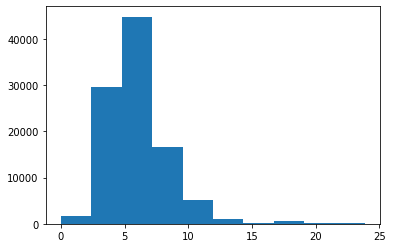

In [ ]:
num_samples = 100000
rnd_idx1 = np.random.randint(X_train.shape[0],size=(num_samples, ))
rnd_idx2 = np.random.randint(X_train.shape[0],size=(num_samples, ))
#x_train_rff = [X_train[rnd_idx1], X_train[rnd_idx2]]
x_train_rff = np.concatenate([X_train[rnd_idx1][:, np.newaxis, ...], 
                          X_train[rnd_idx2][:, np.newaxis, ...]], 
                         axis=1) 
dists = np.linalg.norm(x_train_rff[:, 0, ...] - x_train_rff[:, 1, ...], axis=1)
print(dists.shape)
pl.hist(dists)
print(np.quantile(dists, 0.001))
rnd_idx1 = np.random.randint(X_test.shape[0],size=(num_samples, ))
rnd_idx2 = np.random.randint(X_test.shape[0],size=(num_samples, ))
#x_test_rff = [X_test[rnd_idx1], X_test[rnd_idx2]]
x_test_rff = np.concatenate([X_test[rnd_idx1][:, np.newaxis, ...], 
                          X_test[rnd_idx2][:, np.newaxis, ...]], 
                         axis=1) 

In [ ]:
def gauss_kernel_arr(x, y, gamma):
    return np.exp(-gamma * np.linalg.norm(x - y, axis=1) ** 2)

In [ ]:
import tensorflow as tf

class QFeatureMapAdaptRFF(layers.QFeatureMapRFF):
    def __init__(
                 self,
                 gamma_trainable=True,
                 weights_trainable=True,
                 **kwargs
                 ):
        self.g_trainable = gamma_trainable
        self.w_trainable = weights_trainable
        super().__init__(**kwargs)

    def build(self, input_shape):
        rbf_sampler = RBFSampler(
            gamma=0.5,
            n_components=self.dim,
            random_state=self.random_state)
        x = np.zeros(shape=(1, self.input_dim))
        rbf_sampler.fit(x)
        self.gamma_val = tf.Variable(
            initial_value=self.gamma,
            dtype=tf.float32,
            trainable=self.g_trainable,
            name="rff_gamma")
        self.rff_weights = tf.Variable(
            initial_value=rbf_sampler.random_weights_,
            dtype=tf.float32,
            trainable=self.w_trainable,
            name="rff_weights")
        self.offset = tf.Variable(
            initial_value=rbf_sampler.random_offset_,
            dtype=tf.float32,
            trainable=self.w_trainable,
            name="offset")
        self.built = True

    def call(self, inputs):
        vals = tf.sqrt(2 * self.gamma_val) * tf.matmul(inputs, self.rff_weights) + self.offset # old framework
        vals = tf.cos(vals)
        vals = vals * tf.sqrt(2. / self.dim) # old framework 
        norms = tf.linalg.norm(vals, axis=-1)
        psi = vals / tf.expand_dims(norms, axis=-1)
        return psi

class DMRFF(tf.keras.Model):
    def __init__(self,
                 dim_x,
                 num_rff,
                 gamma=1,
                 random_state=None):
        super().__init__()
        self.rff_layer = QFeatureMapAdaptRFF(input_dim=dim_x, dim=num_rff, gamma=gamma, random_state=random_state, gamma_trainable=False)

    def call(self, inputs):
        x1 = inputs[:, 0]
        x2 = inputs[:, 1]
        phi1 = self.rff_layer(x1)
        phi2 = self.rff_layer(x2)
        dot = tf.einsum('...i,...i->...', phi1, phi2) ** 2
        return dot

def calc_rbf(dmrff, x1, x2):
    return dmrff.predict(np.concatenate([x1[:, np.newaxis, ...], 
                                         x2[:, np.newaxis, ...]], 
                                        axis=1),
                         batch_size=256)


[1.000000e+00 5.000000e-01 2.500000e-01 1.250000e-01 6.250000e-02
 3.125000e-02 1.562500e-02 7.812500e-03 3.906250e-03 1.953125e-03
 9.765625e-04]
Gamma: 0.0078125
6250/6250 [==============================] - 9s 1ms/step - loss: 0.0295


0.029543710872530937

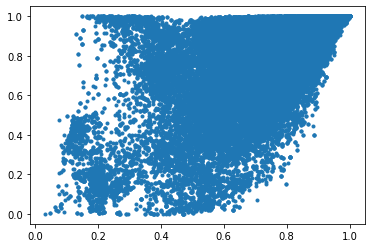

In [ ]:
sigma = np.quantile(dists, 0.01)
gamma = 1/(2 * sigma ** 2)
gamma_index = 7 # index 7 corresponds to gamma = 2**(-7)
gammas = 1/(2**(np.arange(11)))
print(gammas)

n_rffs = 4
print(f'Gamma: {gammas[gamma_index ]}') 
# y_train_rff = gauss_kernel_arr(x_train_rff[:, 0, ...], x_train_rff[:, 1, ...], gamma=gamma) # Original code
# y_test_rff = gauss_kernel_arr(x_test_rff[:, 0, ...], x_test_rff[:, 1, ...], gamma=gamma) # Original code
y_train_rff = gauss_kernel_arr(x_train_rff[:, 0, ...], x_train_rff[:, 1, ...], gamma=gammas[gamma_index ])
y_test_rff = gauss_kernel_arr(x_test_rff[:, 0, ...], x_test_rff[:, 1, ...], gamma=gammas[gamma_index ])
dmrff = DMRFF(dim_x=21, num_rff=n_rffs, gamma=gammas[gamma_index ], random_state=np.random.randint(10000)) # original rs = 0
#dmrff = DMRFF(dim_x=21, num_rff=n_rffs, gamma=gamma / 2, random_state=np.random.randint(10000)) # original rs = 0
dm_rbf = calc_rbf(dmrff, x_test_rff[:, 0, ...], x_test_rff[:, 1, ...])
pl.plot(y_test_rff, dm_rbf, '.')
dmrff.compile(optimizer="adam", loss='mse')
dmrff.evaluate(x_test_rff, y_test_rff, batch_size=16)

Mean: -0.016434483230113983
Std: 0.9815755486488342
Gamma: 0.0078125


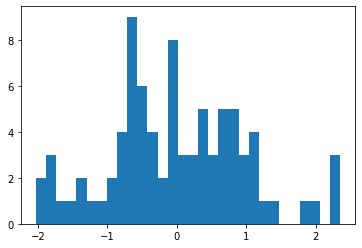

In [ ]:
print(f'Mean: {np.mean(dmrff.rff_layer.rff_weights)}')
print(f'Std: {np.std(dmrff.rff_layer.rff_weights)}')
print(f'Gamma: {dmrff.rff_layer.gamma_val.numpy()}')
pl.hist(dmrff.rff_layer.rff_weights.numpy().flatten(), bins=30);

In [ ]:
dmrff.fit(x_train_rff, y_train_rff, validation_split=0.1, epochs=40, batch_size=128)

Epoch 1/40
704/704 [==============================] - 3s 3ms/step - loss: 0.0232 - val_loss: 0.0179
Epoch 2/40
704/704 [==============================] - 2s 2ms/step - loss: 0.0153 - val_loss: 0.0131
Epoch 3/40
704/704 [==============================] - 2s 2ms/step - loss: 0.0120 - val_loss: 0.0108
Epoch 4/40
704/704 [==============================] - 2s 2ms/step - loss: 0.0102 - val_loss: 0.0095
Epoch 5/40
704/704 [==============================] - 2s 2ms/step - loss: 0.0091 - val_loss: 0.0086
Epoch 6/40
704/704 [==============================] - 2s 2ms/step - loss: 0.0084 - val_loss: 0.0079
Epoch 7/40
704/704 [==============================] - 2s 2ms/step - loss: 0.0078 - val_loss: 0.0073
Epoch 8/40
704/704 [==============================] - 1s 2ms/step - loss: 0.0072 - val_loss: 0.0069
Epoch 9/40
704/704 [==============================] - 2s 2ms/step - loss: 0.0068 - val_loss: 0.0065
Epoch 10/40
704/704 [==============================] - 2s 2ms/step - loss: 0.0065 - val_loss: 0.0063

782/782 [==============================] - 3s 3ms/step - loss: 0.0053


0.005300824996083975

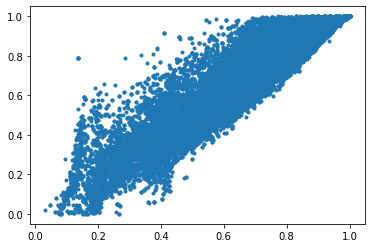

In [ ]:
dm_rbf = calc_rbf(dmrff, x_test_rff[:, 0, ...], x_test_rff[:, 1, ...])
pl.plot(y_test_rff, dm_rbf, '.')
dmrff.evaluate(x_test_rff, y_test_rff, batch_size=128)

Mean: 0.05731048062443733
Std: 0.541689932346344
Gamma: 0.0078125


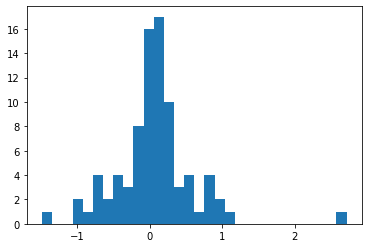

In [ ]:
print(f'Mean: {np.mean(dmrff.rff_layer.rff_weights)}')
print(f'Std: {np.std(dmrff.rff_layer.rff_weights)}')
print(f'Gamma: {dmrff.rff_layer.gamma_val.numpy()}')
pl.hist(dmrff.rff_layer.rff_weights.numpy().flatten(), bins=30);

In [ ]:
X_feat_train = dmrff.rff_layer.call(tf.cast(X_train, tf.float32))
X_feat_test = dmrff.rff_layer.call(tf.cast(X_test, tf.float32))
X_feat_val = dmrff.rff_layer.call(tf.cast(X_val, tf.float32))

X_feat_train = np.float64((X_feat_train).numpy())
X_feat_test = np.float64((X_feat_test).numpy())
X_feat_val = np.float64((X_feat_val).numpy())

X_feat_train = X_feat_train / np.linalg.norm(X_feat_train, axis = 1).reshape(-1, 1)
X_feat_test = X_feat_test / np.linalg.norm(X_feat_test, axis = 1).reshape(-1, 1)
X_feat_val = X_feat_val / np.linalg.norm(X_feat_val, axis = 1).reshape(-1, 1)

X_feat_train.shape, X_feat_test.shape, X_feat_val.shape

((1098, 4), (367, 4), (366, 4))

# IBM Real Computer Attempt

## Pretrained Adp Feautures

In [ ]:
X_feat_train = np.load("/content/drive/MyDrive/TesisMaestria/ResearchData/adpFeatures_4t4_Cardio_train.npy")
X_feat_test = np.load("/content/drive/MyDrive/TesisMaestria/ResearchData/adpFeatures_4t4_Cardio_test.npy")
X_feat_val = np.load("/content/drive/MyDrive/TesisMaestria/ResearchData/adpFeatures_4t4_Cardio_val.npy")

X_feat_train.shape, X_feat_test.shape, X_feat_val.shape

((1098, 4), (367, 4), (366, 4))

## First part

In [ ]:
!pip install qiskit_ibm_runtime

     |████████████████████████████████| 158 kB 3.2 MB/s 
     |████████████████████████████████| 241 kB 37.1 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 138 kB 44.4 MB/s 
     |████████████████████████████████| 50 kB 5.5 MB/s 
  Created wheel for ibm-platform-services: filename=ibm_platform_services-0.24.1-py3-none-any.whl size=257759 sha256=7d0c90638cb070ade3b36b336b6b7efb410adb219688091cce93b2703c1735ab
  Stored in directory: /root/.cache/pip/wheels/39/80/af/0d26d420aeef1beb7fbe475ff282fcee03f0d9c5d08945ad44
  Created wheel for ibm-cloud-sdk-core: filename=ibm_cloud_sdk_core-3.15.1-py3-none-any.whl size=83648 sha256=f04b84500db9181a55cc9bbc1088a11c95317295e51af0e99ba60150f4a01017
  Stored in directory: /root/.cache/pip/wheels/ba/7a/ac/408ba6a1438ea293164dbf26483b13a72165894a31e914b5e6
Successfully built ibm-platform-services ibm-cloud-sdk-core
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, execute, transpile, Aer, assemble
from qiskit.tools.monitor import job_monitor

## Diego's token
TOKEN = '6d2fce5f8e30428840130bd3d576edf3571be02e4d12be8cdd08c7b102699a1931a8fd93be9472b020978fb0fe33d48e2521340e91ea04c0e3c1930cdfbcacf7'

In [ ]:
from qiskit import IBMQ

IBMQ.save_account(TOKEN, overwrite=True) 
provider = IBMQ.load_account()
device = provider.get_backend("ibmq_santiago")

In [ ]:
available_cloud_backends = provider.backends() 
print('\nHere is the list of cloud backends that are available to you:')
for i in available_cloud_backends: print(i)


Here is the list of cloud backends that are available to you:
ibmq_qasm_simulator
ibmq_armonk
ibmq_santiago
ibmq_bogota
ibmq_lima
ibmq_belem
ibmq_quito
simulator_statevector
simulator_mps
simulator_extended_stabilizer
simulator_stabilizer
ibmq_manila


## Qiskit Runtime

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

# Save your credentials on disk.
QiskitRuntimeService.save_account(channel='ibm_quantum', token=TOKEN)

service = QiskitRuntimeService()

In [ ]:
# gamma = [2**-7]
# dim = 4
# num_exps = 1   

# feature_map_fourier = RBFSampler(gamma=gamma[0], n_components=dim)
# feature_map_fourier.fit(X_train)

# rffmap = QFeatureMap_rff(rbf_sampler=feature_map_fourier)
# X_feat_train = rffmap.batch2wf(X_train)
# X_feat_val = rffmap.batch2wf(X_val)
# X_feat_test = rffmap.batch2wf(X_test)


In [ ]:
# print(X_feat_train.shape)
# print(X_feat_val.shape)
# print(X_feat_test.shape)

## Mixed 4x4

### Validation

In [ ]:
from qiskit import transpile

eigvals, U = mixed_state(X_feat_train)

qclist_rff_mixed_val = []

for i in range(len(X_feat_val)): 
    qc = QuantumCircuit(4, 2)

    qc.initialize(X_feat_val[i], [0, 1])
    qc.initialize(np.sqrt(eigvals), [2, 3])
    qc.isometry(U.T, [], [0, 1]) 

    qc.cnot(3, 1)
    qc.cnot(2, 0)

    qc.measure(0, 0)
    qc.measure(1, 1)

    qclist_rff_mixed_val.append(transpile(qc, device))

In [ ]:
indices_rff = list(range(123))

with Sampler(circuits=qclist_rff_mixed_val[0:123], service=service, options={ "backend": "ibmq_santiago" }) as sampler:
    result = sampler(circuit_indices=indices_rff, shots=5000)
    dists = result.quasi_dists

results_rff_mixed_val1 = [dists[i]['00'] for i in range(len(dists))]

In [ ]:
print(results_rff_mixed_val1)

In [ ]:
np.save("/content/drive/MyDrive/TesisMaestria/ResearchData/results_aff_mixed_val1_expsantiago.npy", results_rff_mixed_val1)


In [ ]:
indices_rff = list(range(123))

with Sampler(circuits=qclist_rff_mixed_val[123:246], service=service, options={ "backend": "ibmq_santiago" }) as sampler:
    result = sampler(circuit_indices=indices_rff, shots=5000)
    dists = result.quasi_dists

results_rff_mixed_val2 = [dists[i]['00'] for i in range(len(dists))]

In [ ]:
print(results_rff_mixed_val2)

In [ ]:
np.save("/content/drive/MyDrive/TesisMaestria/ResearchData/results_aff_mixed_val2_expsantiago.npy", results_rff_mixed_val2)


In [ ]:
indices_rff = list(range(120))

with Sampler(circuits=qclist_rff_mixed_val[246:], service=service, options={ "backend": "ibmq_santiago" }) as sampler:
    result = sampler(circuit_indices=indices_rff, shots=5000)
    dists = result.quasi_dists

results_rff_mixed_val3 = [dists[i]['00'] for i in range(len(dists))]

In [ ]:
print(results_rff_mixed_val3)

In [ ]:
np.save("/content/drive/MyDrive/TesisMaestria/ResearchData/results_aff_mixed_val3_expsantiago.npy", results_rff_mixed_val3)

In [ ]:
#results_rff_mixed_val1 = np.load("/content/drive/MyDrive/TesisMaestria/ResearchData/results_aff_mixed_val1_exp2.npy")

In [ ]:
results_rff_mixed_val = np.concatenate((results_rff_mixed_val1, results_rff_mixed_val2, results_rff_mixed_val3), axis=0)

thredhold_mixed = np.percentile(results_rff_mixed_val, q = 9.54)
print(thredhold_mixed)

### Test

In [ ]:
from qiskit import transpile

eigvals, U = mixed_state(X_feat_train)

qclist_rff_mixed_test = []

for i in range(len(X_feat_test)): 
    qc = QuantumCircuit(4, 2)

    qc.initialize(X_feat_test[i], [0, 1])
    qc.initialize(np.sqrt(eigvals), [2, 3])
    qc.isometry(U.T, [], [0, 1]) 

    qc.cnot(3, 1)
    qc.cnot(2, 0)

    qc.measure(0, 0)
    qc.measure(1, 1)

    qclist_rff_mixed_test.append(transpile(qc, device))

In [ ]:
indices_rff = list(range(123))

with Sampler(circuits=qclist_rff_mixed_test[0:123], service=service, options={ "backend": "ibmq_santiago" }) as sampler:
    result = sampler(circuit_indices=indices_rff, shots=5000)
    dists = result.quasi_dists

results_rff_mixed_test1 = [dists[i]['00'] for i in range(len(dists))]

In [ ]:
print(results_rff_mixed_test1)

[0.4674, 0.4512, 0.4388, 0.4386, 0.479, 0.4704, 0.435, 0.508, 0.4784, 0.2928, 0.275, 0.533, 0.4608, 0.4926, 0.4262, 0.4028, 0.5068, 0.4834, 0.389, 0.4574, 0.5352, 0.4538, 0.5162, 0.4556, 0.4476, 0.4472, 0.4856, 0.4918, 0.5008, 0.5128, 0.508, 0.4012, 0.5146, 0.4862, 0.465, 0.4312, 0.3586, 0.523, 0.4718, 0.4566, 0.4142, 0.4816, 0.5094, 0.465, 0.4208, 0.481, 0.507, 0.4982, 0.493, 0.4208, 0.1746, 0.3584, 0.5012, 0.4504, 0.5152, 0.4776, 0.3886, 0.3882, 0.4842, 0.4482, 0.5036, 0.4836, 0.4944, 0.4668, 0.4858, 0.3856, 0.4086, 0.4744, 0.4708, 0.4494, 0.528, 0.4388, 0.5018, 0.4264, 0.4724, 0.2852, 0.5062, 0.4498, 0.481, 0.393, 0.4536, 0.4616, 0.4934, 0.171, 0.4334, 0.437, 0.1792, 0.498, 0.4924, 0.5018, 0.4418, 0.4366, 0.4778, 0.4198, 0.5106, 0.3264, 0.353, 0.4802, 0.4368, 0.51, 0.4918, 0.5056, 0.454, 0.3782, 0.4916, 0.413, 0.4798, 0.3882, 0.206, 0.4342, 0.4068, 0.3678, 0.4994, 0.3352, 0.4132, 0.3272, 0.4308, 0.4254, 0.457, 0.517, 0.4774, 0.3888, 0.494]


In [ ]:
np.save("/content/drive/MyDrive/TesisMaestria/ResearchData/results_aff_mixed_test1_expsantiago.npy", results_rff_mixed_test1)


In [ ]:
indices_rff = list(range(122))

with Sampler(circuits=qclist_rff_mixed_test[123:245], service=service, options={ "backend": "ibmq_santiago" }) as sampler:
    result = sampler(circuit_indices=indices_rff, shots=5000)
    dists = result.quasi_dists

results_rff_mixed_test2 = [dists[i]['00'] for i in range(len(dists))]

In [ ]:
print(results_rff_mixed_test2)

[0.4462, 0.3502, 0.385, 0.5154, 0.4694, 0.491, 0.4852, 0.328, 0.524, 0.4944, 0.4992, 0.4832, 0.4468, 0.503, 0.3696, 0.4832, 0.3798, 0.504, 0.4226, 0.4808, 0.4038, 0.5082, 0.3794, 0.5102, 0.4654, 0.4382, 0.4212, 0.4948, 0.4542, 0.492, 0.4928, 0.3774, 0.3572, 0.4456, 0.4918, 0.477, 0.3592, 0.4994, 0.4848, 0.5238, 0.3844, 0.4916, 0.4572, 0.5072, 0.46, 0.4438, 0.1962, 0.4334, 0.3138, 0.2218, 0.233, 0.4448, 0.5082, 0.475, 0.4564, 0.4814, 0.513, 0.5044, 0.475, 0.4416, 0.5042, 0.5052, 0.191, 0.4494, 0.405, 0.4454, 0.5304, 0.4446, 0.4478, 0.4412, 0.4724, 0.357, 0.456, 0.405, 0.4906, 0.3726, 0.5172, 0.4422, 0.5178, 0.4574, 0.3802, 0.5022, 0.515, 0.5076, 0.5218, 0.4836, 0.4866, 0.4774, 0.5264, 0.403, 0.4834, 0.4796, 0.453, 0.467, 0.5018, 0.51, 0.4844, 0.3158, 0.495, 0.5034, 0.4834, 0.5296, 0.4192, 0.357, 0.4654, 0.4792, 0.5146, 0.4498, 0.4636, 0.4994, 0.4864, 0.4466, 0.4498, 0.5148, 0.5128, 0.4734, 0.4114, 0.464, 0.4592, 0.5036, 0.5058, 0.4564]


In [ ]:
np.save("/content/drive/MyDrive/TesisMaestria/ResearchData/results_aff_mixed_test2_expsantiago.npy", results_rff_mixed_test2)


In [ ]:
indices_rff = list(range(122))

with Sampler(circuits=qclist_rff_mixed_test[245:], service=service, options={ "backend": "ibmq_santiago" }) as sampler:
    result = sampler(circuit_indices=indices_rff, shots=5000)
    dists = result.quasi_dists

results_rff_mixed_test3 = [dists[i]['00'] for i in range(len(dists))]

In [ ]:
print(results_rff_mixed_test3)

[0.4896, 0.5134, 0.197, 0.526, 0.4332, 0.4912, 0.5016, 0.4278, 0.4612, 0.4932, 0.4948, 0.4852, 0.4724, 0.499, 0.4946, 0.4796, 0.4186, 0.4538, 0.4666, 0.4908, 0.3386, 0.543, 0.4456, 0.4898, 0.5292, 0.4858, 0.4926, 0.3978, 0.4222, 0.3182, 0.5114, 0.3302, 0.47, 0.4328, 0.507, 0.4304, 0.4234, 0.4744, 0.4628, 0.4646, 0.4642, 0.4866, 0.4844, 0.4862, 0.353, 0.4756, 0.4688, 0.4388, 0.325, 0.4524, 0.3374, 0.4926, 0.486, 0.4604, 0.5, 0.4576, 0.4342, 0.483, 0.4138, 0.4966, 0.4988, 0.4854, 0.5114, 0.5356, 0.4074, 0.4802, 0.4212, 0.4802, 0.3256, 0.4228, 0.5416, 0.4866, 0.4564, 0.4998, 0.479, 0.3906, 0.4252, 0.4082, 0.461, 0.5048, 0.5472, 0.496, 0.4892, 0.4756, 0.4374, 0.4518, 0.4196, 0.4602, 0.4914, 0.4916, 0.507, 0.2308, 0.504, 0.4356, 0.4632, 0.4306, 0.4912, 0.3596, 0.4824, 0.4714, 0.3742, 0.524, 0.4734, 0.4668, 0.5072, 0.4592, 0.454, 0.4606, 0.2028, 0.516, 0.4764, 0.4934, 0.522, 0.4076, 0.3982, 0.5002, 0.4816, 0.3522, 0.4836, 0.4436, 0.4326, 0.5028]


In [ ]:
np.save("/content/drive/MyDrive/TesisMaestria/ResearchData/results_aff_mixed_test3_expsantiago.npy", results_rff_mixed_test3)


In [ ]:
results_rff_mixed_test = np.concatenate((results_rff_mixed_test1, results_rff_mixed_test2, results_rff_mixed_test3), axis=0)
y_pred_mixed = results_rff_mixed_test > thredhold_mixed

print(classification_report(y_test, y_pred_mixed, digits=4))


              precision    recall  f1-score   support

         0.0     0.5946    0.6286    0.6111        35
         1.0     0.9606    0.9548    0.9577       332

    accuracy                         0.9237       367
   macro avg     0.7776    0.7917    0.7844       367
weighted avg     0.9257    0.9237    0.9247       367



In [ ]:
len(results_rff_mixed_val)

366

In [ ]:
print(f"AUC = {round(roc_auc_score(y_test, results_rff_mixed_test), 4)}")

AUC = 0.9418


## Pure 4x4

### Validation

In [ ]:
U_pure = pure_state(X_feat_train)

qclist_rff_pure_val = []

for i in range(len(X_feat_val)): 
    qc = QuantumCircuit(2, 2)

    qc.initialize(X_feat_val[i], [0, 1])
    qc.isometry(U_pure.T, [], [0, 1]) # ArbRot as a isometry

    qc.measure(0, 0)
    qc.measure(1, 1)

    qclist_rff_pure_val.append(transpile(qc, device))

In [ ]:
indices_rff = list(range(123))

with Sampler(circuits=qclist_rff_pure_val[0:123], service=service, options={ "backend": "ibmq_santiago" }) as sampler:
    result = sampler(circuit_indices=indices_rff, shots=5000)
    dists = result.quasi_dists

results_rff_pure_val1 = [dists[i]['00'] for i in range(len(dists))]

In [ ]:
print(results_rff_pure_val1)

[0.6352, 0.5564, 0.864, 0.835, 0.755, 0.6778, 0.6642, 0.7418, 0.7996, 0.7664, 0.5344, 0.6318, 0.5644, 0.769, 0.4744, 0.5574, 0.8002, 0.9046, 0.7884, 0.8532, 0.7352, 0.7868, 0.8772, 0.7264, 0.8074, 0.8292, 0.8938, 0.6574, 0.6384, 0.8156, 0.7966, 0.8298, 0.8114, 0.696, 0.7102, 0.143, 0.7108, 0.8746, 0.529, 0.7596, 0.7668, 0.6298, 0.8106, 0.7836, 0.7054, 0.8538, 0.5936, 0.6678, 0.808, 0.81, 0.397, 0.8758, 0.8318, 0.5674, 0.4604, 0.7274, 0.7498, 0.6346, 0.7346, 0.7748, 0.626, 0.5034, 0.7552, 0.6828, 0.7712, 0.7658, 0.8286, 0.6576, 0.8534, 0.6206, 0.5278, 0.755, 0.6252, 0.7444, 0.408, 0.8788, 0.5934, 0.8036, 0.7028, 0.4604, 0.6946, 0.7444, 0.7998, 0.8344, 0.601, 0.456, 0.6384, 0.8636, 0.1066, 0.7148, 0.7172, 0.4164, 0.7418, 0.4896, 0.7238, 0.868, 0.696, 0.8994, 0.7922, 0.7566, 0.0526, 0.8816, 0.8376, 0.7868, 0.841, 0.7802, 0.7346, 0.2878, 0.7154, 0.7742, 0.129, 0.449, 0.867, 0.716, 0.8658, 0.4418, 0.7382, 0.6948, 0.6378, 0.7748, 0.8214, 0.8918, 0.7022]


In [ ]:
np.save("/content/drive/MyDrive/TesisMaestria/ResearchData/results_aff_pure_val1_expsantiago.npy", results_rff_pure_val1)


In [ ]:
indices_rff = list(range(123))

with Sampler(circuits=qclist_rff_pure_val[123:246], service=service, options={ "backend": "ibmq_santiago" }) as sampler:
    result = sampler(circuit_indices=indices_rff, shots=5000)
    dists = result.quasi_dists

results_rff_pure_val2 = [dists[i]['00'] for i in range(len(dists))]

In [ ]:
print(results_rff_pure_val2)

[0.8464, 0.8072, 0.7514, 0.7708, 0.8294, 0.7574, 0.7882, 0.5602, 0.8812, 0.8764, 0.7404, 0.6654, 0.8334, 0.8094, 0.412, 0.329, 0.46, 0.7778, 0.7842, 0.8736, 0.523, 0.7476, 0.8144, 0.0894, 0.8038, 0.772, 0.4614, 0.7428, 0.7208, 0.547, 0.7306, 0.8202, 0.601, 0.572, 0.8832, 0.8474, 0.8066, 0.7862, 0.242, 0.7216, 0.7348, 0.5972, 0.8326, 0.7808, 0.769, 0.8382, 0.7884, 0.7196, 0.8236, 0.89, 0.8148, 0.6676, 0.799, 0.8356, 0.3034, 0.7392, 0.8328, 0.626, 0.7964, 0.7388, 0.7566, 0.8648, 0.84, 0.849, 0.7714, 0.8376, 0.281, 0.6734, 0.8152, 0.7772, 0.0378, 0.742, 0.5692, 0.7162, 0.8404, 0.5616, 0.791, 0.768, 0.653, 0.8342, 0.7378, 0.7924, 0.5956, 0.7952, 0.8412, 0.6106, 0.5334, 0.7244, 0.5296, 0.866, 0.8188, 0.8768, 0.7538, 0.8022, 0.8302, 0.8854, 0.7858, 0.839, 0.783, 0.7978, 0.626, 0.822, 0.8666, 0.4556, 0.6882, 0.7796, 0.8358, 0.706, 0.7974, 0.541, 0.8216, 0.5108, 0.8486, 0.8958, 0.6492, 0.6568, 0.7388, 0.8666, 0.7572, 0.5338, 0.4968, 0.849, 0.9112]


In [ ]:
np.save("/content/drive/MyDrive/TesisMaestria/ResearchData/results_aff_pure_val2_expsantiago.npy", results_rff_pure_val2)


In [ ]:
indices_rff = list(range(120))

with Sampler(circuits=qclist_rff_pure_val[246:], service=service, options={ "backend": "ibmq_santiago" }) as sampler:
    result = sampler(circuit_indices=indices_rff, shots=5000)
    dists = result.quasi_dists

results_rff_pure_val3 = [dists[i]['00'] for i in range(len(dists))]

In [ ]:
print(results_rff_pure_val3)

[0.7266, 0.396, 0.7336, 0.8978, 0.7342, 0.7998, 0.8486, 0.7846, 0.7366, 0.7228, 0.795, 0.631, 0.7986, 0.7836, 0.8208, 0.5668, 0.8634, 0.8318, 0.8082, 0.7282, 0.8286, 0.7208, 0.8006, 0.835, 0.6964, 0.6018, 0.8222, 0.799, 0.7008, 0.7484, 0.4976, 0.4458, 0.7444, 0.688, 0.5154, 0.797, 0.8268, 0.7678, 0.636, 0.8872, 0.6012, 0.8022, 0.645, 0.783, 0.7204, 0.79, 0.589, 0.3416, 0.8842, 0.6976, 0.6058, 0.8878, 0.7504, 0.6642, 0.8926, 0.8536, 0.7676, 0.781, 0.8636, 0.8474, 0.75, 0.8376, 0.7184, 0.8168, 0.798, 0.6688, 0.6694, 0.6314, 0.801, 0.6836, 0.3018, 0.8726, 0.8044, 0.852, 0.6564, 0.7286, 0.6808, 0.6866, 0.6652, 0.7994, 0.5718, 0.8906, 0.851, 0.7322, 0.8296, 0.4448, 0.7964, 0.7824, 0.178, 0.7416, 0.8444, 0.8488, 0.741, 0.726, 0.56, 0.6858, 0.8522, 0.6522, 0.4512, 0.773, 0.4322, 0.8598, 0.6428, 0.8086, 0.8158, 0.6268, 0.8758, 0.6796, 0.173, 0.7964, 0.6668, 0.8592, 0.6784, 0.6624, 0.642, 0.7742, 0.7456, 0.6942, 0.7684, 0.6482]


In [ ]:
np.save("/content/drive/MyDrive/TesisMaestria/ResearchData/results_aff_pure_val3_expsantiago.npy", results_rff_pure_val3)


In [ ]:
results_rff_pure_val = np.concatenate((results_rff_pure_val1, results_rff_pure_val2, results_rff_pure_val3), axis=0)

thredhold_pure = np.percentile(results_rff_pure_val, q = 9.54)
print(thredhold_pure)

0.4974568


### Test

In [ ]:
U_pure = pure_state(X_feat_train)

qclist_rff_pure_test = []

for i in range(len(X_feat_test)): 
    qc = QuantumCircuit(2, 2)

    qc.initialize(X_feat_test[i], [0, 1])
    qc.isometry(U_pure.T, [], [0, 1]) # ArbRot as a isometry

    qc.measure(0, 0)
    qc.measure(1, 1)

    qclist_rff_pure_test.append(transpile(qc, device))

In [ ]:
indices_rff = list(range(123))

with Sampler(circuits=qclist_rff_pure_test[0:123], service=service, options={ "backend": "ibmq_santiago" }) as sampler:
    result = sampler(circuit_indices=indices_rff, shots=5000)
    dists = result.quasi_dists

results_rff_pure_test1 = [dists[i]['00'] for i in range(len(dists))]

In [ ]:
print(results_rff_pure_test1)

[0.786, 0.7204, 0.799, 0.7494, 0.8322, 0.8224, 0.7354, 0.8596, 0.8228, 0.3738, 0.3764, 0.914, 0.628, 0.8896, 0.6976, 0.7208, 0.8616, 0.839, 0.528, 0.7326, 0.9146, 0.7002, 0.863, 0.8234, 0.751, 0.7948, 0.8714, 0.8718, 0.8534, 0.8668, 0.8554, 0.609, 0.8814, 0.774, 0.784, 0.6546, 0.536, 0.8256, 0.8038, 0.7988, 0.7676, 0.805, 0.9086, 0.8392, 0.644, 0.759, 0.907, 0.768, 0.8372, 0.687, 0.0954, 0.4434, 0.8712, 0.7354, 0.8782, 0.8144, 0.651, 0.5516, 0.8546, 0.6838, 0.8126, 0.8588, 0.8236, 0.8166, 0.7866, 0.6048, 0.6018, 0.794, 0.7792, 0.812, 0.8842, 0.803, 0.892, 0.647, 0.8132, 0.2682, 0.8396, 0.714, 0.7708, 0.5488, 0.79, 0.7918, 0.7244, 0.1272, 0.6356, 0.8078, 0.05, 0.8106, 0.85, 0.8378, 0.6892, 0.7904, 0.8264, 0.7546, 0.8808, 0.4536, 0.5846, 0.8584, 0.6816, 0.862, 0.802, 0.857, 0.697, 0.5322, 0.8436, 0.6848, 0.7906, 0.6702, 0.1632, 0.7504, 0.602, 0.5506, 0.8326, 0.3718, 0.6862, 0.4496, 0.7478, 0.6564, 0.7204, 0.8938, 0.7806, 0.5522, 0.8172]


In [ ]:
np.save("/content/drive/MyDrive/TesisMaestria/ResearchData/results_aff_pure_test1_expsantiago.npy", results_rff_pure_test1)


In [ ]:
indices_rff = list(range(122))

with Sampler(circuits=qclist_rff_pure_test[123:245], service=service, options={ "backend": "ibmq_santiago" }) as sampler:
    result = sampler(circuit_indices=indices_rff, shots=5000)
    dists = result.quasi_dists

results_rff_pure_test2 = [dists[i]['00'] for i in range(len(dists))]

In [ ]:
print(results_rff_pure_test2)

[0.7874, 0.4892, 0.6582, 0.8128, 0.7826, 0.8212, 0.8274, 0.5742, 0.9216, 0.8056, 0.8448, 0.806, 0.711, 0.8374, 0.5396, 0.792, 0.5136, 0.8472, 0.6318, 0.8452, 0.6782, 0.8556, 0.645, 0.863, 0.6448, 0.6994, 0.71, 0.8038, 0.819, 0.8242, 0.8578, 0.6446, 0.4684, 0.704, 0.7834, 0.7322, 0.4596, 0.8456, 0.7924, 0.9028, 0.4608, 0.8924, 0.6868, 0.8712, 0.7732, 0.7706, 0.0866, 0.7178, 0.2858, 0.0846, 0.1648, 0.8022, 0.8124, 0.8432, 0.8232, 0.7154, 0.8328, 0.8706, 0.8176, 0.7124, 0.8634, 0.8468, 0.1028, 0.7448, 0.4732, 0.7302, 0.911, 0.6658, 0.7042, 0.6966, 0.7712, 0.481, 0.63, 0.6368, 0.8316, 0.4512, 0.8862, 0.7228, 0.9008, 0.8114, 0.5224, 0.7944, 0.885, 0.894, 0.847, 0.7998, 0.8414, 0.8386, 0.8866, 0.68, 0.8074, 0.804, 0.7076, 0.767, 0.8302, 0.9008, 0.7766, 0.4648, 0.8766, 0.8554, 0.8164, 0.9036, 0.5626, 0.4744, 0.8086, 0.8072, 0.9024, 0.7956, 0.8036, 0.7952, 0.7714, 0.8096, 0.7246, 0.8736, 0.906, 0.7978, 0.6616, 0.759, 0.7892, 0.878, 0.8294, 0.7244]


In [ ]:
np.save("/content/drive/MyDrive/TesisMaestria/ResearchData/results_aff_pure_test2_expsantiago.npy", results_rff_pure_test2)


In [ ]:
indices_rff = list(range(122))

with Sampler(circuits=qclist_rff_pure_test[245:], service=service, options={ "backend": "ibmq_santiago" }) as sampler:
    result = sampler(circuit_indices=indices_rff, shots=5000)
    dists = result.quasi_dists

results_rff_pure_test3 = [dists[i]['00'] for i in range(len(dists))]

In [ ]:
print(results_rff_pure_test3)

[0.8608, 0.8418, 0.126, 0.8796, 0.6782, 0.8436, 0.8262, 0.6708, 0.72, 0.8102, 0.8606, 0.8768, 0.8126, 0.8458, 0.8432, 0.7992, 0.7168, 0.7918, 0.7706, 0.827, 0.509, 0.902, 0.5986, 0.8152, 0.8768, 0.7946, 0.8608, 0.4862, 0.7112, 0.3604, 0.8682, 0.432, 0.8206, 0.7412, 0.7716, 0.6776, 0.619, 0.721, 0.7594, 0.7258, 0.7954, 0.8052, 0.8176, 0.8794, 0.6144, 0.7774, 0.789, 0.7168, 0.4406, 0.7964, 0.5354, 0.8398, 0.8182, 0.6886, 0.794, 0.7896, 0.7552, 0.758, 0.686, 0.799, 0.8692, 0.7298, 0.8332, 0.9172, 0.5752, 0.7388, 0.6612, 0.8006, 0.4918, 0.622, 0.9208, 0.7772, 0.7944, 0.815, 0.7856, 0.6628, 0.7058, 0.6574, 0.76, 0.838, 0.9016, 0.8276, 0.8562, 0.7968, 0.7818, 0.744, 0.7328, 0.8166, 0.8158, 0.8316, 0.8228, 0.141, 0.8442, 0.7624, 0.7244, 0.6336, 0.8388, 0.467, 0.8092, 0.7942, 0.5646, 0.8638, 0.836, 0.8518, 0.845, 0.7394, 0.764, 0.766, 0.1044, 0.8726, 0.842, 0.8272, 0.8858, 0.6766, 0.5222, 0.8254, 0.8554, 0.568, 0.7864, 0.7518, 0.6898, 0.831]


In [ ]:
np.save("/content/drive/MyDrive/TesisMaestria/ResearchData/results_aff_pure_test3_expsantiago.npy", results_rff_pure_test3)


In [ ]:
results_rff_pure_val1 = np.load("/content/drive/MyDrive/TesisMaestria/ResearchData/results_aff_pure_val1.npy")
results_rff_pure_val2 = np.load("/content/drive/MyDrive/TesisMaestria/ResearchData/results_aff_pure_val2.npy")
results_rff_pure_val3 =  np.load("/content/drive/MyDrive/TesisMaestria/ResearchData/results_aff_pure_val3.npy")

results_rff_pure_val1 = np.sqrt(results_rff_pure_val1)
results_rff_pure_val2 = np.sqrt(results_rff_pure_val2)
results_rff_pure_val3 = np.sqrt(results_rff_pure_val3)

results_rff_pure_val = np.concatenate((results_rff_pure_val1, results_rff_pure_val2, results_rff_pure_val3), axis=0)

results_rff_pure_val1.shape, results_rff_pure_val2.shape, results_rff_pure_val3.shape, results_rff_pure_val.shape

((123,), (123,), (120,), (366,))

In [ ]:
thredhold_pure = np.percentile(results_rff_pure_val, q = 9.54)
print(thredhold_pure)

0.6937008891460926


In [ ]:
results_rff_pure_test1 = np.load("/content/drive/MyDrive/TesisMaestria/ResearchData/results_aff_pure_test1.npy")
results_rff_pure_test2 = np.load("/content/drive/MyDrive/TesisMaestria/ResearchData/results_aff_pure_test2.npy")
results_rff_pure_test3 =  np.load("/content/drive/MyDrive/TesisMaestria/ResearchData/results_aff_pure_test3.npy")


results_rff_pure_test1 = np.sqrt(results_rff_pure_test1)
results_rff_pure_test2 = np.sqrt(results_rff_pure_test2)
results_rff_pure_test3 = np.sqrt(results_rff_pure_test3)

results_rff_pure_test = np.concatenate((results_rff_pure_test1, results_rff_pure_test2, results_rff_pure_test3), axis=0)

results_rff_pure_test1.shape, results_rff_pure_test2.shape, results_rff_pure_test3.shape, results_rff_pure_test.shape

((123,), (122,), (122,), (367,))

In [ ]:
results_rff_pure_test = np.concatenate((results_rff_pure_test1, results_rff_pure_test2, results_rff_pure_test3), axis=0)

y_pred_pure = results_rff_pure_test > thredhold_pure

print(classification_report(y_test, y_pred_pure, digits=4))

              precision    recall  f1-score   support

         0.0     0.7353    0.7143    0.7246        35
         1.0     0.9700    0.9729    0.9714       332

    accuracy                         0.9482       367
   macro avg     0.8526    0.8436    0.8480       367
weighted avg     0.9476    0.9482    0.9479       367



In [ ]:
print(f"AUC = {round(roc_auc_score(y_test, results_rff_pure_test), 4)}")

AUC = 0.9681


## Classical Pred AdpRFF

In [ ]:
from sklearn.metrics import roc_curve, f1_score
from sklearn.metrics import classification_report

def classification(preds_val, preds_test, y_test):

    thredhold = np.percentile(preds_val, q = 9.54)
    y_pred = preds_test > thredhold
    return classification_report(y_test, y_pred, digits=4)

In [ ]:
#gamma = dmrff.rff_layer.gamma_val.numpy()
dim = 4

print(f"{dim}x{dim} Pure, experiment AdaptiveRFF")
#print("Gamma:", gamma)

## Training pure state and create the Unitary matrix to initialize such state

psi_train = X_feat_train.sum(axis = 0)
psi_train = psi_train / np.linalg.norm(psi_train)

preds_val_expected = np.sqrt((X_feat_val @ psi_train)**2)
preds_test_expected = np.sqrt((X_feat_test @ psi_train)**2)

print(classification(preds_val_expected, preds_test_expected, y_test))
print(f"AUC = {round(roc_auc_score(y_test, preds_test_expected), 4)}")

4x4 Pure, experiment AdaptiveRFF
              precision    recall  f1-score   support

         0.0     0.7273    0.6857    0.7059        35
         1.0     0.9671    0.9729    0.9700       332

    accuracy                         0.9455       367
   macro avg     0.8472    0.8293    0.8379       367
weighted avg     0.9442    0.9455    0.9448       367

AUC = 0.967


In [ ]:
#gamma = dmrff.rff_layer.gamma_val.numpy()
dim = 4

print(f"{dim}x{dim} mixed, experiment AdaptiveRFF")
#print("Gamma:", gamma)

## Training mixed state and create the Unitary matrix to initialize such state
rho_train = np.zeros((dim, dim))


#for i in range(1000):
for i in range(len(X_feat_train)):
  rho_train += np.outer(X_feat_train[i], X_feat_train[i])

rho_train = rho_train / len(X_feat_train)

# Classical prediction
preds_val_mixed = np.zeros(len(X_feat_val))

for i in range(len(X_feat_val)):
  preds_val_mixed[i] = X_feat_val[i].T @ rho_train @ X_feat_val[i]

preds_test_mixed = np.zeros(len(X_feat_test))

for i in range(len(X_feat_test)):
  preds_test_mixed[i] = X_feat_test[i].T @ rho_train @ X_feat_test[i]

print(classification(preds_val_mixed, preds_test_mixed, y_test))
print(f"AUC = {round(roc_auc_score(y_test, preds_test_mixed), 4)}")

4x4 mixed, experiment AdaptiveRFF
              precision    recall  f1-score   support

         0.0     0.7027    0.7429    0.7222        35
         1.0     0.9727    0.9669    0.9698       332

    accuracy                         0.9455       367
   macro avg     0.8377    0.8549    0.8460       367
weighted avg     0.9470    0.9455    0.9462       367

AUC = 0.9657
